<a href="https://colab.research.google.com/github/nahidmaleki/Cross-Validation/blob/main/CrossValidation(IrisDataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🔁 Cross-Validation — Honest Model Evaluation
Goal: Estimate out-of-sample performance reliably and compare models/hyper-params without leakage.

🧠 Why CV?
Training and evaluating on the same data overstates performance. CV mimics “new data” by rotating held-out folds and averaging results → mean ± std gives both performance and stability.

🧰 What you’ll get
Bias–variance intuition (why one split is fragile)

CV patterns and when to use them

Guardrails to prevent leakage

A mini checklist you can paste atop any notebook

🗂️ CV patterns (pick the right splitter)
KFold → default for regression / balanced data

StratifiedKFold → classification with class imbalance (keeps class ratios)

GroupKFold → grouped data (patients/users/projects must not cross folds)

TimeSeriesSplit → temporal data (train past → validate future)

Repeated KFold/Stratified → more stable estimates via multiple runs

Nested CV → inner loop tunes, outer loop reports honest performance

🚧 Guardrails (no-leak checklist)
Put all preprocessing in a Pipeline (scale/encode inside CV)

Shuffle folds unless time matters

Report the metric + mean ± std across folds

Use stratification for classifiers; groups for correlated rows

Keep a final test set untouched until the very end

⚠️ Common pitfalls
Fitting scalers/encoders on the whole dataset (leakage)

Selecting features using all data before CV

Tuning on the test set (overly optimistic)

Comparing models on different splits

📌 TL;DR
CV = rotate, train, evaluate, average. Use the right splitter, keep preprocessing inside a pipeline, and reserve a truly final test set.


In [1]:
import numpy as np
import matplotlib.pyplot as plt   # Import matplotlib

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, log_loss

import warnings
warnings.filterwarnings(action='ignore')


In [2]:
iris = load_iris()
iris.data.shape, iris.target.shape


((150, 4), (150,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data[:, :2], iris.target, test_size=0.25, random_state=2022
    )

X_train.shape, y_train.shape


((112, 2), (112,))

In [4]:
X_test.shape, y_test.shape


((38, 2), (38,))

In [5]:
clf = LogisticRegression(solver='lbfgs', verbose=1).fit(X_train, y_train)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [6]:
clf.score(X_train, y_train)


0.8035714285714286

In [7]:
clf.score(X_test, y_test)


0.8947368421052632

In [8]:
y_pred = clf.predict(X_test)


In [9]:
accuracy_score(y_test, y_pred)


0.8947368421052632

In [10]:
score = cross_val_score(
    clf, iris.data[:,:3], iris.target, cv=5, scoring='accuracy'
)
score


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


array([0.93333333, 1.        , 0.9       , 0.93333333, 1.        ])

Final test accuracy:  0.8157894736842105


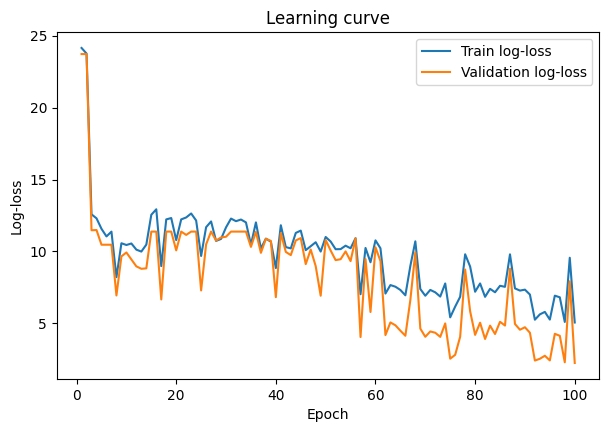

In [11]:
# SGD logistic regression (multiclass) so we can step through epochs
classes = np.unique(y_train)
clf = SGDClassifier(
    loss="log_loss",    # logistic regression
    penalty="l2",
    alpha=1e-4,
    learning_rate="optimal",
    max_iter=1,   # we'll drive epochs with partial_fit
    tol=None,
    random_state=2022
)

n_epoches = 100
train_losses, test_losses = [], []

# first update must pass classes
clf.partial_fit(X_train, y_train, classes=classes)

for _ in range (n_epoches):
  # record current loss
  train_losses.append(log_loss(y_train, clf.predict_proba(X_train), labels=classes))
  test_losses.append(log_loss(y_test, clf.predict_proba(X_test), labels=classes))
  # one more epoch
  clf.partial_fit(X_train, y_train)

print("Final test accuracy: ", accuracy_score(y_test, clf.predict(X_test)))

#plot
plt.figure(figsize=(7,4.5))
plt.plot(range(1, n_epoches+1), train_losses, label="Train log-loss")
plt.plot(range(1, n_epoches+1), test_losses, label="Validation log-loss")
plt.xlabel("Epoch"); plt.ylabel("Log-loss"); plt.legend(); plt.title("Learning curve")
plt.tight_layout; plt.show()


# Cross validation iterators
The following sections list utilities to generate indices that can be used to generate dataset splits according to different cross validation strategies.

Assuming that some data is Independent Identically Distributed (i.i.d.) is making the assumption that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples.

The following cross-validators can be used in such cases.

In [13]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)
X = ["a", "b", "c", "d", "e", "f"]
for train, test in kf.split(X):
  print("%s %s" % (train, test))


[2 3 4 5] [0 1]
[0 1 2 4 5] [3]
[0 1 2 3 5] [4]
[0 1 3 4 5] [2]
[0 1 2 3 4] [5]


In [14]:
from sklearn.model_selection import StratifiedKFold

kf = KFold(n_splits=5, shuffle=True)
X = ["a", "b", "c", "d", "e", "f"]
for train, test in kf.split(X):
    print("%s %s" % (train, test))


[2 3 4 5] [0 1]
[0 1 3 4 5] [2]
[0 1 2 3 5] [4]
[0 1 2 3 4] [5]
[0 1 2 4 5] [3]


In [15]:
from sklearn.model_selection import StratifiedKFold

X = np.ones(10)
y = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))


[2 3 6 7 8 9] [0 1 4 5]
[0 1 3 4 5 8 9] [2 6 7]
[0 1 2 4 5 6 7] [3 8 9]


# Grouped Data
The i.i.d. assumption is broken if the underlying generative process yield groups of dependent samples.

Such a grouping of data is domain specific. An example would be when there is medical data collected from multiple patients, with multiple samples taken from each patient. And such data is likely to be dependent on the individual group. In our example, the patient id for each sample will be its group identifier.

In this case we would like to know if a model trained on a particular set of groups generalizes well to the unseen groups. To measure this, we need to ensure that all the samples in the validation fold come from groups that are not represented at all in the paired training fold.

The following cross-validation splitters can be used to do that. The grouping identifier for the samples is specified via the groups parameter.

In [16]:
from sklearn.model_selection import GroupKFold

X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10]
y = ["a", "b", "b", "b", "c", "c", "c", "d", "d", "d"]
groups = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3]

gkf = GroupKFold(n_splits=3)
for train, test in gkf.split(X, y, groups=groups):
    print("%s %s" % (train, test))


[0 1 2 3 4 5] [6 7 8 9]
[0 1 2 6 7 8 9] [3 4 5]
[3 4 5 6 7 8 9] [0 1 2]


# Time Series Split
TimeSeriesSplit is a variation of k-fold which returns first k folds as train set and the (k+1) th fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the model.

This class can be used to cross-validate time series data samples that are observed at fixed time intervals.

In [17]:
from sklearn.model_selection import TimeSeriesSplit

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)

for train, test in tscv.split(X):
    print("%s %s" % (train, test))


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]
